# First computer exercise in Machine Learning: Unsuperised methods

## Part A: PCA

Write a function that performs PCA on a (note necessarily centered) data in a 2D numpy array. The function should return the pca transformed data along with the eigenvalues and eigenvectors of the tranformation. Use the numpy package. 

In [2]:
import numpy as np
# Use the numpy eigenvalue solver for the covariance matrix
E, V = np.linalg.eig(np.array([[0,2], [1, 1]]))
# The solver doesn't return ordered eigenvalues, so we have to fix this
key = np.argsort(E)[::-1]
V = V[:,key]
E = E[key]
print(E)
print(V)

[ 2. -1.]
[[-0.70710678 -0.89442719]
 [-0.70710678  0.4472136 ]]


In [3]:
# delete me: https://stackoverflow.com/questions/13224362/principal-component-analysis-pca-in-python
def PCA2(data, pca_components=2):
    """
    PCA with eigenvalues
    
    :param data: A 2d numpy array where data.shape == (number_of_data_points, dimensionality_of_data_points)
    :returns: tuple (U, E, V) 
        WHERE
        U is a numpy array of the pca transformed data
        E is an ordered numpy array of eigenvalues
        V is an ordered numpy array of eigenvectors
    """
    ### YOUR CODE STARTS HERE ###
    
    m, n = data.shape
    # mean center the data
    data -= data.mean(axis=0)
    # calculate the covariance matrix
    R = np.cov(data, rowvar=False)
    # calculate eigenvectors & eigenvalues of the covariance matrix
    # use 'eigh' rather than 'eig' since R is symmetric, 
    # the performance gain is substantial
    evals, evecs = np.linalg.eig(R)
    # sort eigenvalue in decreasing order
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    # sort eigenvectors according to same index
    E = evals[idx]
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    V = evecs[:, :pca_components]
    U = np.dot(V.T, data.T).T
    
    ### YOUR CODE ENDS HERE ###
    return (U, E, V)

We will begin with the MNIST data set https://en.wikipedia.org/wiki/MNIST_database. It is commonly used for "hello world" purposes in machine learning.

The shape of the data vector XX is: (1797, 64)
The shape of the label vector YY is: (1797,)


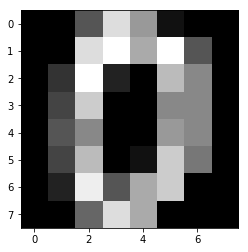

In [11]:
import matplotlib.pyplot as plt 
from course_utils import *

#  The images have been scaled down to 8x8 pixels, and will be stored in a flat numpy vector. 
XX, YY = load_mnist_data()
print("The shape of the data vector XX is: {}".format(XX.shape))
print("The shape of the label vector YY is: {}" .format(YY.shape))
# Display a sample
plt.imshow(np.reshape(XX[0,:], (8, 8)), cmap="gray")
plt.show()

Check that your function outputs a solution that agrees with the canonical python implementation of PCA

In [5]:
from sklearn.decomposition import PCA
(U, E, V) = PCA2(XX, 2)
pca = PCA(n_components=2)
pca.fit(XX)
if V.shape != pca.components_.shape:
    print("You should transpose your eigenvector output")
    assert(np.allclose(np.transpose(V), pca.components_, atol=1))
    print("Success!")
else: 
    assert(np.allclose(V, pca.components_, atol=1))
    print("Success!")
    

You should transpose your eigenvector output
Success!


In [6]:
X, Y = load_ini_data2()
clusters = len(np.unique(Y))

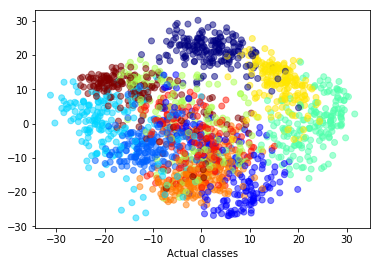

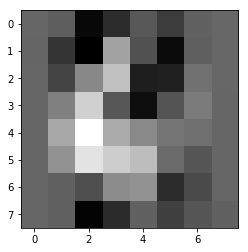

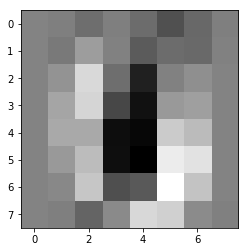

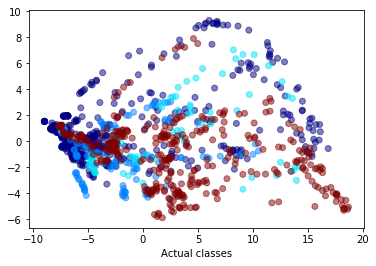

IndexError: tuple index out of range

In [7]:
# Viz with 2 pca components
pca = PCA(n_components=2)
pca_features = pca.fit_transform(XX)
# pca_features = > function from assignment 2 <
plt.xlabel('Actual classes')
plt.scatter(pca_features[:,0], pca_features[:,1], c=YY, alpha=0.5, cmap="jet")
plt.show()
for i in range(2):
    comp_image = np.reshape(pca.components_[i], (8,8))
    plt.imshow(comp_image, cmap="gray")
    plt.show()
pca = PCA(n_components=2)
pca_features = pca.fit_transform(X)
# pca_features = > function from assignment 2 <
plt.xlabel('Actual classes')
plt.scatter(pca_features[:,0], pca_features[:,1], c=Y, alpha=0.5, cmap="jet")
plt.show()
for i in range(2):
    comp_image = np.reshape(pca.components_[i], (X.shape[1], X.shape[2]))
    plt.imshow(comp_image, cmap="gray")
    plt.show()


In [ ]:
Part B: K-Means clustering

In [ ]:
# Viz with 2 sfa features
from sklearn.cluster import KMeans
import mdp

sfa = mdp.nodes.SFANode(output_dim=2)
slow_features = sfa.execute(X)
# slow_features = > function from assignment 5 <  
kmeans = KMeans(init='random', n_clusters=clusters)
kmeans.fit(slow_features)
classes = kmeans.predict(slow_features)
# classes = > function from assignment 3 <  
plt.scatter(slow_features[:,0], slow_features[:,1], c=Y, cmap="jet")
plt.xlabel("Actual classes")
plt.show()

plt.scatter(slow_features[:,0], slow_features[:,1], c=classes)
plt.xlabel("Predicted clustering")
plt.show()

In [ ]:
# Same as above, but now with SFA features. 
# Here they should find that all metrics are significantly better
# with a good number of SFA features: turns out that exploiting
# the knowledge that the data is ordered is pretty useful.
from time import time
from sklearn import metrics

sfa_features = [2, 5, 10, 20, 50, 99]
for features in sfa_features:  
    t0 = time()
    sfa = mdp.nodes.SFANode(output_dim=features)
    slow_features = sfa.execute(X)
    # slow_features = > function from assignment 5 <  
    kmeans = KMeans(init='random', n_clusters=clusters)
    kmeans.fit(slow_features)
    classes = kmeans.predict(slow_features)
    # classes = > function from assignment 3 <  
    print("{} sfa components, Purity: {:.2}, ARI: {:.2}, Seconds: {:.2} ".format(features,
                                             purity_score(Y, classes),
                                             metrics.adjusted_rand_score(Y, classes),
                                                              time() - t0))
    
t0 = time()
kmeans = KMeans(init='random', n_clusters=clusters)
kmeans.fit(X)
classes = kmeans.predict(X)
# classes = > function from assignment 3 <  

print("raw pixels\t , Purity: {:.2}, ARI: {:.2}, Seconds: {:.2}".format(purity_score(Y, classes),
                                    metrics.adjusted_rand_score(Y, classes),
                                    time() - t0))


In [1]:
# Functions that I imagine requiring students to implement: 
# purity_score(y_true, y_predicted), davies_bouldin_score(X, y_predicted)
# the equivalent of pca.fit_transform(n_components, X) and kmeans.predict(n_clusters, X)
# and some sort of "sfa.fit_transform(n_features, X)"